In [1]:
import pandas as pd
import numpy as np
##\
import pickle as pk
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.cuda.is_available()

False

In [3]:
movie_file="./data/movies_clean_full.csv"
rating_file="./data/ratings_clean_full.csv"
samples_file = "samples_rnd_full.pk"
ratings_pd = pd.read_csv(rating_file)
movied_pd = pd.read_csv(movie_file, index_col=["movieId"], header=0)

In [4]:
args = {
    "batch_size" : 1000,
    "embedding_size" : 10,
    "epoch": 1,
    "lr": 0.1,
    }

movies_size= len(movied_pd)
user_size = ratings_pd["userId"].nunique()


In [5]:
class ItemDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        target_category = torch.tensor()
        context_category = torch.tensor()
        target = torch.tensor(self.data[index][0], dtype=torch.long)
        context = torch.tensor(self.data[index][1], dtype=torch.long)
        label = torch.tensor(self.data[index][2], dtype=torch.float32)

        return target, context, label

    def __len__(self):
        return len(self.data)
#split samples here
with open(samples_file, 'rb') as file:
    # Call load method to deserialze
    samples = pk.load(file)
item_dataset = ItemDataset(samples)
train_loader = DataLoader(item_dataset, batch_size=args["batch_size"], shuffle=True)
loss_vals = []
acc_vals = []

In [110]:
print(samples[5])
print(len(samples))

[0, [32, 3008, 7729, 7771, 3566, 2974], [1, 0, 0, 0, 0, 0]]
4578119


In [197]:
print(samples[:1])

[[0, [14, 9231, 639, 9114, 5491, 8446], [1, 0, 0, 0, 0, 0]]]


In [195]:
import random
genere_embed = nn.Embedding(20, 4)
genere_list = {'Comedy', 'War', 'Romance', 'Horror', 'IMAX', '(no genres listed)', 'Documentary', 'Adventure', 'Drama', 'Fantasy', 'Animation', 'Film-Noir', 'Thriller', 'Action', 'Children', 'Musical', 'Mystery', 'Sci-Fi', 'Western', 'Crime'}
genere_to_id = dict()
id_to_genere = dict()
for idx,genere in enumerate(genere_list):
    genere_to_id[genere] = idx
    id_to_genere[idx] = genere

gval = genere_embed.weight[1]
mval = model.shared_embedding.weight[1]
print(mval)
print(gval)

concat = torch.cat((mval,gval),dim=0)
print(concat)
#Need category per movie

# print(model.shared_embedding.weight)
# print(genere_to_id)

# t = torch.tensor([])
# print(t.shape)
# for i in range(model.shared_embedding.weight.shape[0]):
#     category = random.choice(movied_pd.iloc[i]["genres"].split('|'))
#     genered_embed = genere_embed(torch.tensor(genere_to_id[category]))
#     if i == 0 :
#         t = genered_embed
#     else :
#         t = torch.stack((t, genered_embed), dim=0)
# print(t)

tensor([-0.1820, -0.1524,  0.2839,  0.4781,  0.7424,  0.3419,  1.3038,  0.5505,
         0.3006, -0.1380], grad_fn=<SelectBackward0>)
tensor([-0.3841, -0.6770, -0.0674, -0.0601], grad_fn=<SelectBackward0>)
tensor([-0.1820, -0.1524,  0.2839,  0.4781,  0.7424,  0.3419,  1.3038,  0.5505,
         0.3006, -0.1380, -0.3841, -0.6770, -0.0674, -0.0601],
       grad_fn=<CatBackward0>)


In [111]:
class ItemVectorModel(nn.Module):
    def __init__(self, args):
        super(ItemVectorModel, self).__init__()
        self.shared_embedding = nn.Embedding(movies_size, args["embedding_size"])
        self.activation = nn.Sigmoid()

    def forward(self, target, context):
        context_emb = self.shared_embedding(context)
        movie_emb = self.shared_embedding(target)
        dots = torch.einsum('be,bce->bc', movie_emb, context_emb)
        return dots
        
    def fit(self, train_loader, epoch=args["epoch"], lr=args["lr"]):
        self.train()
        optimizer = optim.Adam(self.parameters())
        loss_func = nn.BCEWithLogitsLoss()
        for i in range(1, epoch+1):
            #target.shape batch, : context.shape batch x neg_c ; label.shape = batch x neg_c
            correct = 0
            total = 0
            iter = 0
            for target, context, label in train_loader:
                self.zero_grad()
                x = self.forward(target, context)
                loss = loss_func(x, label)
                loss.backward()
                optimizer.step()
   
                iter += 1
                if iter % 500 == 0 :
                    loss_vals.append(loss.item())
                    print(f"iter {iter}/{len(train_loader)} loss: {loss.item()}", end='\r')
                    with torch.no_grad():
                        pred = torch.argmax(self.activation(x), dim=1)
                        lbl = torch.argmax(label, dim=1)
                        total += lbl.size(0)
                        correct += (pred == lbl).sum().item()
                        acc_vals.append(100 * correct / total)
            accuracy = 100 * correct / total
            print(f"epoch {i}/{epoch} loss: {loss.item()}\taccuracy: {accuracy}")


In [112]:
model = ItemVectorModel(args)

In [121]:
model.fit(train_loader, epoch=5)


epoch 1/5 loss: 0.17118369042873383	accuracy: 83.94444444444444
epoch 2/5 loss: 0.14579801261425018	accuracy: 84.4888888888889
epoch 3/5 loss: 0.14462397992610931	accuracy: 84.45555555555555
epoch 4/5 loss: 0.15052944421768188	accuracy: 84.35555555555555
epoch 5/5 loss: 0.1504761278629303	accuracy: 84.65555555555555


In [115]:
def ranking(query_liked, query_disliked):
    with torch.no_grad():
        # weights = model.activation(model.shared_embedding.weight.detach()).numpy()
        weights = model.shared_embedding.weight.detach().numpy()

        query_res = weights[query_liked].sum(axis=0)
        if(len(query_disliked) > 0):
            query_res = np.subtract(query_res, weights[query_disliked].sum(axis=0))
        outs = list()
        for idx,movie in movied_pd["title"].items():
            movie = weights[idx]
            vector_dot = np.dot(movie, query_res)
            movie_1_length = np.linalg.norm(movie,2)
            query_length = np.linalg.norm(query_res,2)
            cosine_dist =  (vector_dot / (movie_1_length * query_length))
            # print(outs)
            outs.append(cosine_dist)
        return torch.tensor(np.stack(outs,0))

In [116]:
def display_top_k(score, indices, k=5):
    top_scores = score[:k]
    top_indic = indices[:k]
    top_names = []
    top_generes = []

    for movie_id in top_indic:
        top_names.append(movied_pd.loc[movie_id.item()]["title"])
        top_generes.append(movied_pd.loc[movie_id.item()]["genres"])
        
    df = pd.DataFrame({
        "score_key": top_scores.numpy(),
        'titles':top_names,
        'genres': top_generes
    })
    print(df)

In [122]:
query_liked = [0]
query_disliked = []
topk = 10

print("===========COSINE SIMILARITY===================")
score, indices = ranking(query_liked,query_disliked).sort(descending=True)
display_top_k(score,indices, topk)



===========COSINE SIMILARITY===================
   score_key                                             titles  \
0   1.000000                                   Toy Story (1995)   
1   0.986410                                        Heat (1995)   
2   0.986184                       Sense and Sensibility (1995)   
3   0.985423              Ace Ventura: When Nature Calls (1995)   
4   0.984869  City of Lost Children, The (Cité des enfants p...   
5   0.982242                                      Casino (1995)   
6   0.981563                                   GoldenEye (1995)   
7   0.979111                            Dead Man Walking (1995)   
8   0.977948                             Dead Presidents (1995)   
9   0.977197                                        Babe (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                        Action|Crime|Thriller  
2                                Drama|Romance  
3                 

In [107]:
print(model.shared_embedding.weight)

Parameter containing:
tensor([[-0.0236,  0.2563,  0.1305,  ...,  0.4506, -0.4474,  0.0611],
        [ 0.1589,  0.4065,  0.1521,  ...,  0.1098, -0.2722,  0.0370],
        [ 0.0545,  0.2190, -0.0290,  ...,  0.2887, -0.4086,  0.1857],
        ...,
        [-1.5067, -2.4089, -0.1978,  ...,  0.2855,  1.8867, -4.2286],
        [-1.5542, -1.8567, -0.6149,  ...,  1.1403,  2.1166, -3.1297],
        [-1.4342, -2.3658, -0.2565,  ...,  1.5176,  2.7043, -3.5839]],
       requires_grad=True)


In [90]:
# %%
import numpy as np
import matplotlib.pylab as plt
from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline

n_components = 2
tsne = TSNE(n_components)
model_normalized_space = model.activation(model.shared_embedding.weight.detach())
tsne_result = tsne.fit_transform(model_normalized_space)
tsne_result.shape
# y =  movied_pd["genres"].map(lambda x : x.split('|')[0])
y =  movied_pd["title"]

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
axx = sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=5)
lim = (tsne_result.min(), tsne_result.max())
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# # %%
# x = model.embedding_space.weight[:,0]
# y = model.embedding_space.weight[:,1]
# plt.scatter(x.detach(),y.detach())

C:\Users\Nicholas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Nicholas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Image size of 1634x204067 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'accuracy')

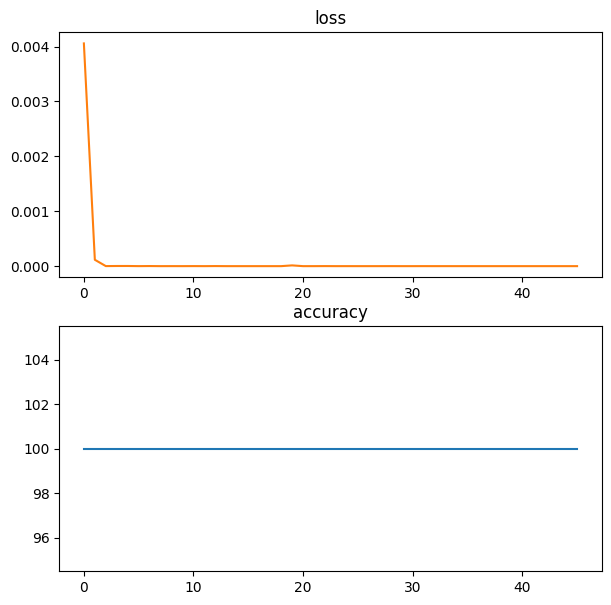

In [1375]:
import matplotlib.pylab as plt
fig, axs = plt.subplots(2,figsize=(7, 7))
# fig.suptitle('Vertically stacked subplots')
axs[0].plot(loss_vals, 'tab:orange')
axs[0].set_title('loss')

axs[1].plot(acc_vals, label="accuracy")
axs[1].set_title('accuracy')

# plt.plot(loss_vals, label = "loss")
# plt.plot(acc_vals, label = "accuracy")

In [903]:
torch.save(model.state_dict(), 'model_pytorch3.h5')

In [1251]:
context_emb = model.shared_embedding(torch.tensor([1,2,3,4,5]))
movie_emb = model.shared_embedding(torch.tensor([6]))
print(context_emb.shape)
print(movie_emb.shape)
# dots = torch.einsum('be,bce->bc', movie_emb, context_emb)

print(movie_emb.T.shape)
print(context_emb)
# print(dots)
other = movie_emb @ context_emb.T
print(other)

torch.Size([5, 2])
torch.Size([1, 2])
torch.Size([2, 1])
tensor([[ 0.3816, -0.0205],
        [-1.2910, -0.1754],
        [ 0.4043, -1.2051],
        [-0.6019,  0.5514],
        [ 0.5551, -0.0626]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.3277, -1.1570,  0.1121, -0.4137,  0.4701]], grad_fn=<MmBackward0>)


In [1257]:
context_emb = model.shared_embedding(torch.tensor([[1,2,3,4,5],[1,2,3,4,5]]))
movie_emb = model.shared_embedding(torch.tensor([6,6]))
print(context_emb.shape)
print(movie_emb.shape)
dots = movie_emb @ context_emb.T
print(dots)



torch.Size([2, 5, 2])
torch.Size([2, 2])


C:\Users\Nicholas\AppData\Local\Temp\ipykernel_28840\3634187933.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  dots = movie_emb @ context_emb.T


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x5 and 2x2)

In [1253]:
context_emb = model.shared_embedding(torch.tensor([[1,2,3,4,5],[1,2,3,4,5]]))
movie_emb = model.shared_embedding(torch.tensor([6,6]))
print(context_emb.shape)
print(movie_emb.shape)
dots = torch.einsum('be,bce->bc', movie_emb, context_emb)
print(dots)



torch.Size([2, 5, 2])
torch.Size([2, 2])
tensor([[ 0.3277, -1.1570,  0.1121, -0.4137,  0.4701],
        [ 0.3277, -1.1570,  0.1121, -0.4137,  0.4701]],
       grad_fn=<ViewBackward0>)


In [1334]:
embedding_matrix = torch.rand(2,50)
other = torch.rand(2, 1)
print(other)
pool = nn.AvgPool1d(10)
x = pool(embedding_matrix)
print(x)

cat = torch.cat([x,other], dim=1)
print(cat)

tensor([[0.6106],
        [0.9894]])
tensor([[0.3777, 0.6375, 0.4384, 0.5464, 0.5856],
        [0.5381, 0.4222, 0.6403, 0.4121, 0.5445]])
tensor([[0.3777, 0.6375, 0.4384, 0.5464, 0.5856, 0.6106],
        [0.5381, 0.4222, 0.6403, 0.4121, 0.5445, 0.9894]])
